In [1]:
import numpy as np
import os
import torch
import datetime
import time
import matplotlib.pyplot as plt

from flow.networks.ring import RingNetwork
from flow.core.params import VehicleParams
from flow.controllers.car_following_models import IDMController #Human driving model
from flow.controllers.routing_controllers import ContinuousRouter #Router that keeps vehicles on the ring-road
from flow.networks.ring import ADDITIONAL_NET_PARAMS
from flow.core.params import NetParams
from flow.core.params import InitialConfig
from flow.core.params import TrafficLightParams
from flow.envs.ring.accel import AccelEnv
from flow.envs.ring.accel import ADDITIONAL_ENV_PARAMS
from flow.core.params import SumoParams
from flow.core.params import EnvParams
from flow.core.experiment import Experiment
import flow.visualize.visualize_ring as visualize_ring

import utils
from Detectors.Deep_Learning.AutoEncoders.utils import sliding_window, SeqDataset, train_epoch, eval_data
from Detectors.Deep_Learning.AutoEncoders.cnn_lstm_ae import CNNRecurrentAutoencoder

print("libraries loaded.")

libraries loaded.


In [2]:
# Simulate an instance without attack
sim_res_list_no_attack = utils.run_ring_sim_no_attack()

Running ring simulation, ring length: 300


/home/zhenxianglance/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy-1.18.4-py3.7-linux-x86_64.egg/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/zhenxianglance/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy-1.18.4-py3.7-linux-x86_64.egg/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 3629.1459930322335
data/ring_no_attack_20221026-0011241666761084.7746775-0_emission.csv data
Average, std velocities: 7.37676037747105, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 3629.1459930322335, 0.0
Total time: 16.48322606086731
steps/second: 341.8918193902368


## NOTE TO ZHEN: 

This is a small, but important difference. The make_train_X function takes in a list of lists of np arrays. In the below code I changed it to add [speed] to the speeds_list list, rather than speed directly. Below I also showed how you can do this for multiple features.

In [3]:
# Load training data
# local_emission_path = 'data/ring_no_attack_20221018-1554371666126477.4290931-0_emission.csv'
emission_path = os.path.join(os.getcwd(),sim_res_list_no_attack[1])

timeseries_dict = visualize_ring.get_sim_timeseries(csv_path = emission_path,
                                                    warmup_period=50.0)

# Store speeds here:
speeds_list = []
for veh_id in timeseries_dict:
    speeds_list.append([timeseries_dict[veh_id][:,1]])
    
speeds = []
for veh_id in timeseries_dict:
    speeds.append(timeseries_dict[veh_id][:,1])    

speed_diffs_list = []
for i in range(len(speeds)):
    speed_diffs_list.append([speeds[i] - speeds[i-1]])


Data loaded, total time: 0.41925525665283203


In [4]:
print(speeds_list)

[[array([7.67064614, 7.67231078, 7.67376472, ..., 8.61833324, 8.51898252,
       8.41768648])], [array([7.67608843, 7.67527852, 7.6742629 , ..., 7.39585724, 7.28980235,
       7.18448042])], [array([7.65376874, 7.65079921, 7.64767829, ..., 6.25477205, 6.16681141,
       6.08113757])], [array([7.61027899, 7.60599274, 7.60163766, ..., 5.4033822 , 5.34517106,
       5.28974646])], [array([7.55721484, 7.55263502, 7.54806568, ..., 4.91032455, 4.88368833,
       4.85963755])], [array([7.50643433, 7.50239498, 7.49841645, ..., 4.76200144, 4.76253023,
       4.76510894])], [array([7.4653854 , 7.4622939 , 7.45927571, ..., 4.89102171, 4.91180869,
       4.93400417])], [array([7.43755405, 7.43534925, 7.4331994 , ..., 5.21203228, 5.24548128,
       5.27835491])], [array([7.41918443, 7.41752041, 7.41588314, ..., 5.63815533, 5.67895025,
       5.72004179])], [array([7.40536357, 7.40387228, 7.40239183, ..., 6.11001714, 6.15102769,
       6.19460907])], [array([7.39167498, 7.39022878, 7.38880275, ..., 

In [5]:
# Initialize autoencoder
embedding_dim = 32
cnn_channels = 8
kernel_size = 16
stride = 1
batch_size = 16
# device = 'cuda' #Change to cuda if appropriate
device = 'cpu'
n_features=1 #Number of features, in the case only 1: speed
seq_len = 100 #How many samples from the time-series we look at per time
model = CNNRecurrentAutoencoder(seq_len,
                                n_features,
                                embedding_dim,
                                cnn_channels, 
                                kernel_size, 
                                stride, 
                                device)
model = model.to(device)
model = model.train()

# Training configurations
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

print('Model initialized.')

Model initialized.


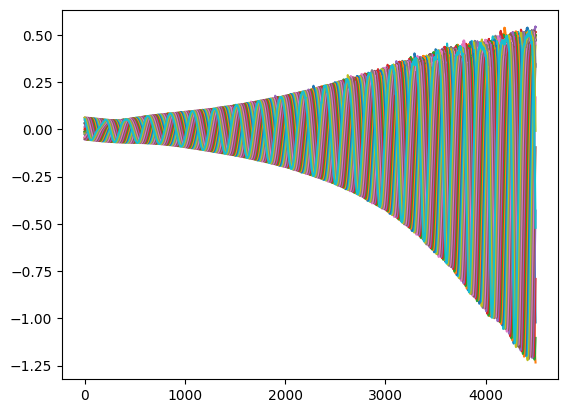

In [6]:
#Added by George to check the right quantity is in this data structure:
import matplotlib.pyplot as pt
for speed_diff in speed_diffs_list:
    pt.plot(speed_diff[0])
# Appears correct:

In [8]:
from importlib import reload
import Detectors.Deep_Learning.AutoEncoders.utils
reload(Detectors.Deep_Learning.AutoEncoders.utils)

# This is added by George:
from Detectors.Deep_Learning.AutoEncoders.utils import make_train_X

# This function randomly samples the same number of samples from the provided list of timeseries
# where the same number are sampled from each timeseries (which corresponds to a single vehicle)
num_samples_per_veh = 10
train_X = make_train_X(timeseries_list=speed_diffs_list, #This is the list of timeseries for your feature
                       num_samples_per_veh = num_samples_per_veh,
                       seq_len = seq_len)



# trainset = SeqDataset(speeds)
trainset = SeqDataset(train_X) #George added this and commented out above
# Below remains from Zhen's code:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)

n_epoch = 500 #George changws this from 500 to 10 just to test on his machine
best_loss = 999999
for e in range(n_epoch):
    l = train_epoch(model=model, optimizer=optimizer, dataloader=trainloader)
    if e % 10 == 0:
        print(e, l)



0 0.48395833253860476
10 0.5428421545028687
20 0.4185276162624359
30 0.41129032969474794
40 0.41632994413375857
50 0.3252017557621002
60 0.35868879318237307
70 0.2610944616794586
80 0.20614954829216003
90 0.262815762758255
100 0.2176864981651306
110 0.18276559948921203
120 0.20245064795017242
130 0.2586892819404602
140 0.2015946650505066
150 0.19962666392326356
160 0.19246671617031097
170 0.18247414231300355
180 0.224193594455719
190 0.16765612840652466
200 0.16844363749027252
210 0.13842977046966554
220 0.17942929446697234
230 0.1443232226371765
240 0.14377781987190247
250 0.11985432654619217
260 0.11551405847072602
270 0.138624826669693
280 0.13393002569675447
290 0.13813795059919357
300 0.14120379388332366
310 0.21202756345272064
320 0.15166817784309386
330 0.13399489402770995
340 0.13897090435028076
350 0.11382308185100555
360 0.13072605490684508
370 0.1674387800693512
380 0.13786776781082152
390 0.09639571338891983
400 0.13748482644557952
410 0.13724575698375702
420 0.109635959565

In [9]:
import utils
from Adversaries.controllers.car_following_adversarial import FollowerStopper_Overreact

# Define our advesary:
adversary = (FollowerStopper_Overreact, {'v_des':10,
                                        'braking_rate':-3.0,
                                        'braking_period':5.0})

In [10]:
sim_res_list_with_attack = utils.run_ring_sim_with_attack(adversary=adversary)

Running adversarial ring simulation: 
(<class 'Adversaries.controllers.car_following_adversarial.FollowerStopper_Overreact'>, {'v_des': 10, 'braking_rate': -3.0, 'braking_period': 5.0})
Braking engaged, time 7.1000000000000005
Braking engaged, time 36.0
Braking engaged, time 43.5
Braking engaged, time 72.10000000000001
Braking engaged, time 101.0
Braking engaged, time 109.2
Braking engaged, time 137.9
Braking engaged, time 147.0
Braking engaged, time 175.5
Braking engaged, time 185.20000000000002
Braking engaged, time 213.60000000000002
Braking engaged, time 223.20000000000002
Braking engaged, time 251.70000000000002
Braking engaged, time 261.40000000000003
Braking engaged, time 289.8
Braking engaged, time 299.6
Braking engaged, time 328.1
Braking engaged, time 338.20000000000005
Braking engaged, time 366.6
Braking engaged, time 376.5
Braking engaged, time 404.90000000000003
Braking engaged, time 415.0
Braking engaged, time 443.40000000000003
Braking engaged, time 453.3
Braking engaged

/home/zhenxianglance/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy-1.18.4-py3.7-linux-x86_64.egg/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/zhenxianglance/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy-1.18.4-py3.7-linux-x86_64.egg/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 1686.9352692073844
data/ring_with_attack_20221026-0028191666762099.9002502-0_emission.csv data
Average, std velocities: 4.517048258677167, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 1686.9352692073844, 0.0
Total time: 15.059147357940674
steps/second: 372.4343687086134


Data loaded.


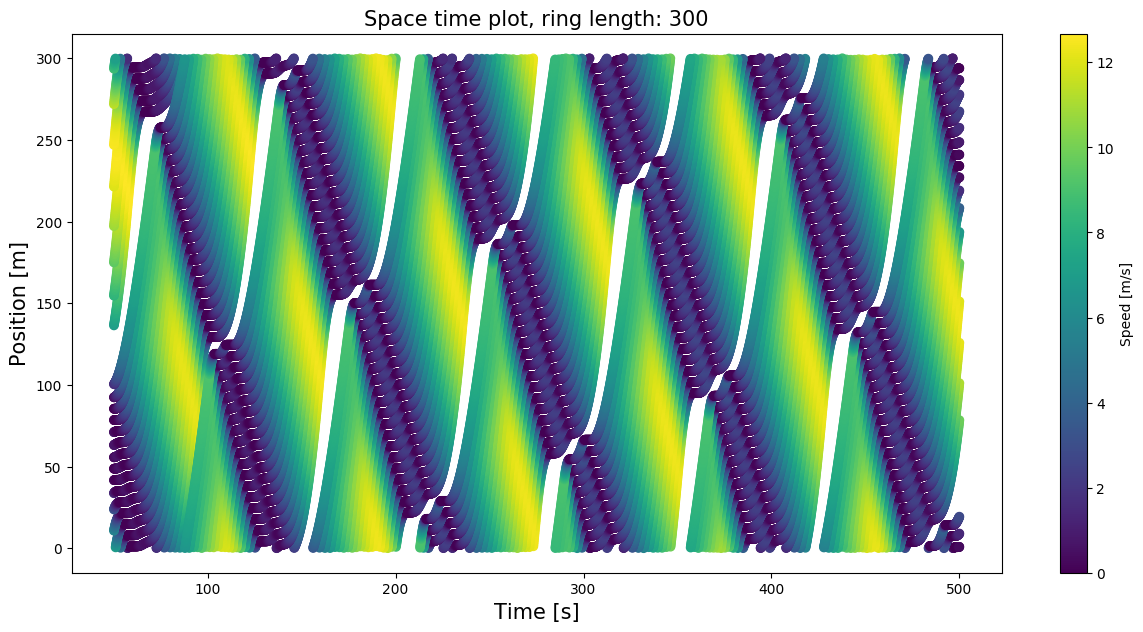

In [11]:
emission_path = os.path.join(os.getcwd(),sim_res_list_with_attack[1])
visualize_ring.make_ring_spacetime_fig(csv_path = emission_path)

In [15]:
from Detectors.Deep_Learning.AutoEncoders.utils import eval_data

timeseries_dict_attack = visualize_ring.get_sim_timeseries(csv_path = emission_path,
                                                    warmup_period=50.0)
veh_ids_attack = list(timeseries_dict_attack.keys())

#Get speeds again:
speeds_attack = []
for veh_id in veh_ids_attack:
    speeds_attack.append(timeseries_dict_attack[veh_id][:,1])

speed_diffs_list_attack = []
for i in range(len(speeds_attack)):
    speed_diffs_list_attack.append([speeds_attack[i] - speeds_attack[i-1]])

test_X = make_train_X(timeseries_list=speed_diffs_list_attack, #This is the list of timeseries for your feature
                       num_samples_per_veh = num_samples_per_veh,
                       seq_len = seq_len)

# trainset = SeqDataset(speeds)
testset = SeqDataset(test_X) #George added this and commented out above
# Below remains from Zhen's code:
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

ls, tot = eval_data(model, testloader)

print(ls)

    






Data loaded, total time: 0.454531192779541


RuntimeError: The size of tensor a (16) must match the size of tensor b (100) at non-singleton dimension 1

In [8]:
# Try same thing but with multiple features:

timeseries_list_training = []

for veh_id in timeseries_dict:
    speed = timeseries_dict[veh_id][:,1]
    speed_diffs = timeseries_dict[veh_id][:,3]

    timeseries_list_training.append([speed,speed_diffs])


# Initialize autoencoder
embedding_dim = 32
cnn_channels = 8
kernel_size = 16
stride = 1
batch_size = 16
# device = 'cuda' #Change to cuda if appropriate
device = 'cpu'
n_features=2 #Number of features, in the case only 1: speed
seq_len = 100 #How many samples from the time-series we look at per time
model = CNNRecurrentAutoencoder(seq_len,
                                n_features,
                                embedding_dim,
                                cnn_channels, 
                                kernel_size, 
                                stride, 
                                device)
model = model.to(device)
model = model.train()

# Training configurations
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

print('Model initialized.')

num_samples_per_veh = 10
train_X = make_train_X(timeseries_list=timeseries_list_training, #This is the list of timeseries for your feature
                       num_samples_per_veh = num_samples_per_veh,
                       seq_len = seq_len)



# trainset = SeqDataset(speeds)
trainset = SeqDataset(train_X) #George added this and commented out above
# Below remains from Zhen's code:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)

n_epoch = 10 #George changws this from 500 to 10 just to test on his machine
best_loss = 999999
for e in range(n_epoch):
    l = train_epoch(model=model, optimizer=optimizer, dataloader=trainloader)
    print(e)

Model initialized.
0
1
2
3
4
5
6
7
8
9
